In [2]:
import numpy as np
import pandas as pd
import pickle as pk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
# parse data to end at affect
RAW_FEATURES = ['time_taken', 'correct', 'original', 'hint', 'hintcount', 'total_hints', 'scaffold', 'bottom_hint', 'attemptcount', 'no_prob_type', 'algebra', 'choose_1', 'choose_n', 'fill_in_1', 'open_response']
EXPERT_FEATURES = ['avg_attemptCount', 'avg_bottomHint', 'avg_correct', 'avg_frIsHelpRequest', 'avg_frPast5HelpRequest', 'avg_frPast5WrongCount', 'avg_frPast8HelpRequest', 'avg_frPast8WrongCount', 'avg_frWorkingInSchool', 'avg_hint', 'avg_hintCount', 'avg_hintTotal', 'avg_original', 'avg_past8BottomOut', 'avg_scaffold', 'avg_stlHintUsed', 'avg_timeSinceSkill', 'avg_timeTaken', 'avg_totalFrAttempted', 'avg_totalFrPastWrongCount', 'avg_totalFrPercentPastWrong', 'avg_totalFrSkillOpportunities', 'avg_totalFrTimeOnSkill', 'max_attemptCount', 'max_bottomHint', 'max_correct', 'max_frIsHelpRequest', 'max_frPast5HelpRequest', 'max_frPast5WrongCount', 'max_frPast8HelpRequest', 'max_frPast8WrongCount', 'max_frWorkingInSchool', 'max_hint', 'max_hintCount', 'max_hintTotal', 'max_original', 'max_past8BottomOut', 'max_scaffold', 'max_stlHintUsed', 'max_timeSinceSkill', 'max_timeTaken', 'max_totalFrAttempted', 'max_totalFrPastWrongCount', 'max_totalFrPercentPastWrong', 'max_totalFrSkillOpportunities', 'max_totalFrTimeOnSkill', 'min_attemptCount', 'min_bottomHint', 'min_correct', 'min_frIsHelpRequest', 'min_frPast5HelpRequest', 'min_frPast5WrongCount', 'min_frPast8HelpRequest', 'min_frPast8WrongCount', 'min_frWorkingInSchool', 'min_hint', 'min_hintCount', 'min_hintTotal', 'min_original', 'min_past8BottomOut', 'min_scaffold', 'min_stlHintUsed', 'min_timeSinceSkill', 'min_timeTaken', 'min_totalFrAttempted', 'min_totalFrPastWrongCount', 'min_totalFrPercentPastWrong', 'min_totalFrSkillOpportunities', 'min_totalFrTimeOnSkill', 'sum_attemptCount', 'sum_bottomHint', 'sum_correct', 'sum_frIsHelpRequest', 'sum_frPast5HelpRequest', 'sum_frPast5WrongCount', 'sum_frPast8HelpRequest', 'sum_frPast8WrongCount', 'sum_frWorkingInSchool', 'sum_hint', 'sum_hintCount', 'sum_hintTotal', 'sum_original', 'sum_past8BottomOut', 'sum_scaffold', 'sum_stlHintUsed', 'sum_timeSinceSkill', 'sum_timeTaken', 'sum_totalFrAttempted', 'sum_totalFrPastWrongCount', 'sum_totalFrPercentPastWrong', 'sum_totalFrSkillOpportunities', 'sum_totalFrTimeOnSkill']
TARGET_FEATURES = ['confusion', 'concentration', 'boredom', 'frustration']

padded_raw_length = []
padded_raw_input = []
padded_raw_target = []
padded_raw_weight = []
padded_expert_length = []
padded_expert_input = []
padded_expert_target = []
padded_expert_weight = []
bagged_raw_length = []
bagged_raw_input = []
bagged_raw_target = []
bagged_expert_length = []
bagged_expert_input = []
bagged_expert_target = []

def parse_data(df):
    global padded_raw_length
    global padded_raw_input
    global padded_raw_target
    global padded_raw_weight
    global padded_expert_length
    global padded_expert_input
    global padded_expert_target
    global padded_expert_weight
    global bagged_raw_length
    global bagged_raw_input
    global bagged_raw_target
    global bagged_expert_length
    global bagged_expert_input
    global bagged_expert_target
    if (df[TARGET_FEATURES].sum(axis=1) == 1).sum() > 0:
        padded_raw_length.append(len(df))
        padded_raw_input.append(df[RAW_FEATURES].values)
        padded_raw_target.append(df[TARGET_FEATURES].values)
        padded_raw_weight.append(df[TARGET_FEATURES].sum(axis=1).values)
        df = df.reset_index(drop=True)
        for i, row in df.iterrows():
            if row[TARGET_FEATURES].sum() == 1:
                bagged_raw_length.append(i+1)
                bagged_raw_input.append(df.iloc[:i+1][RAW_FEATURES].values)
                bagged_raw_target.append(df.iloc[i][TARGET_FEATURES].values)
        keepers = df['avg_attemptCount'].notna()
        df = df[keepers]
        padded_expert_length.append(len(df))
        padded_expert_input.append(df[EXPERT_FEATURES].values)
        padded_expert_target.append(df[TARGET_FEATURES].values)
        padded_expert_weight.append(df[TARGET_FEATURES].sum(axis=1).values)
        df = df.reset_index(drop=True)
        for i, row in df.iterrows():
            if row[TARGET_FEATURES].sum() == 1:
                bagged_expert_length.append(i+1)
                bagged_expert_input.append(df.iloc[:i+1][EXPERT_FEATURES].values)
                bagged_expert_target.append(df.iloc[i][TARGET_FEATURES].values)

def pad_data(a, max_length):
    pad = []
    if len(a.shape) == 2:
        pad = np.zeros((max_length - a.shape[0], a.shape[1]))
    else:
        pad = np.zeros((max_length - a.shape[0],))
    return np.concatenate([pad, a])

data = pd.read_csv('affect_behavior_action_clips.csv')
data[RAW_FEATURES + TARGET_FEATURES] = data[RAW_FEATURES + TARGET_FEATURES].fillna(0)
data = data[data[TARGET_FEATURES].sum(axis=1) < 2]
data = data.sort_values(['user_id.x', 'time_sequence', 'start_time', 'attemptcount']).reset_index()
data = data.groupby(['user_id.x', 'time_sequence', 'assignment_id.x']).apply(parse_data)

max_raw_length = max(padded_raw_length)
padded_raw_input = [pad_data(i, max_raw_length) for i in padded_raw_input]
padded_raw_target = [pad_data(i, max_raw_length) for i in padded_raw_target]
padded_raw_weight = [pad_data(i, max_raw_length) for i in padded_raw_weight]

max_expert_length = max(padded_expert_length)
padded_expert_input = [pad_data(i, max_expert_length) for i in padded_expert_input]
padded_expert_target = [pad_data(i, max_expert_length) for i in padded_expert_target]
padded_expert_weight = [pad_data(i, max_expert_length) for i in padded_expert_weight]

pk.dump(padded_raw_input, open('padded_raw_input.pkl', 'wb'))
pk.dump(padded_raw_target, open('padded_raw_target.pkl', 'wb'))
pk.dump(padded_raw_weight, open('padded_raw_weight.pkl', 'wb'))
pk.dump(padded_expert_input, open('padded_expert_input.pkl', 'wb'))
pk.dump(padded_expert_target, open('padded_expert_target.pkl', 'wb'))
pk.dump(padded_expert_weight, open('padded_expert_weight.pkl', 'wb'))
pk.dump(bagged_raw_input, open('bagged_raw_input.pkl', 'wb'))
pk.dump(bagged_raw_target, open('bagged_raw_target.pkl', 'wb'))
pk.dump(bagged_expert_input, open('bagged_expert_input.pkl', 'wb'))
pk.dump(bagged_expert_target, open('bagged_expert_target.pkl', 'wb'))


(24,)
(13,)
(3,)
(11,)
(15,)
(11,)
(11,)
(7,)
(16,)
(16,)
(3,)
(8,)
(11,)
(13,)
(83,)
(11,)
(12,)
(27,)
(43,)
(16,)
(14,)
(37,)
(16,)
(1,)
(5,)
(3,)
(35,)
(15,)
(52,)
(5,)
(5,)
(7,)
(13,)
(3,)
(12,)
(31,)
(46,)
(3,)
(48,)
(20,)
(35,)
(23,)
(16,)
(44,)
(91,)
(16,)
(9,)
(36,)
(11,)
(5,)
(77,)
(3,)
(1,)
(10,)
(20,)
(18,)
(5,)
(3,)
(6,)
(6,)
(8,)
(6,)
(32,)
(1,)
(15,)
(9,)
(22,)
(117,)
(78,)
(74,)
(11,)
(23,)
(3,)
(5,)
(12,)
(20,)
(10,)
(14,)
(26,)
(24,)
(28,)
(40,)
(33,)
(8,)
(1,)
(32,)
(37,)
(25,)
(10,)
(8,)
(3,)
(10,)
(4,)
(8,)
(24,)
(4,)
(9,)
(9,)
(3,)
(11,)
(12,)
(25,)
(1,)
(23,)
(3,)
(15,)
(5,)
(7,)
(6,)
(1,)
(24,)
(22,)
(3,)
(28,)
(6,)
(29,)
(16,)
(21,)
(15,)
(15,)
(28,)
(20,)
(9,)
(27,)
(24,)
(41,)
(62,)
(8,)
(6,)
(56,)
(20,)
(14,)
(9,)
(25,)
(6,)
(7,)
(5,)
(7,)
(9,)
(43,)
(12,)
(7,)
(303,)
(31,)
(7,)
(15,)
(6,)
(12,)
(21,)
(5,)
(5,)
(22,)
(19,)
(23,)
(25,)
(27,)
(5,)
(16,)
(3,)
(3,)
(8,)
(21,)
(8,)
(16,)
(20,)
(25,)
(2,)
(5,)
(4,)
(3,)
(18,)
(2,)
(3,)
(25,)
(9,)
(3,)
(3,)
(4,)
(5,

(66,)
(6,)
(39,)
(25,)
(23,)
(6,)
(69,)
(13,)
(17,)
(7,)
(31,)
(42,)
(30,)
(47,)
(44,)
(35,)
(14,)
(20,)
(19,)
(42,)
(15,)
(9,)
(32,)
(21,)
(50,)
(21,)
(25,)
(20,)
(11,)
(52,)
(31,)
(68,)
(64,)
(35,)
(80,)
(330,)
(39,)
(46,)
(66,)
(12,)
(71,)
(43,)
(60,)
(23,)
(16,)
(62,)
(5,)
(17,)
(27,)
(4,)
(13,)
(50,)
(8,)
(35,)
(27,)
(37,)
(42,)
(39,)
(50,)
(32,)
(76,)
(53,)
(42,)
(61,)
(13,)
(15,)
(68,)
(57,)
(31,)
(50,)
(96,)
(90,)
(25,)
(55,)
(109,)
(125,)
(60,)
(34,)
(27,)
(61,)
(6,)
(31,)
(25,)
(20,)
(12,)
(13,)
(25,)
(27,)
(15,)
(5,)
(26,)
(8,)
(17,)
(34,)
(14,)
(26,)
(18,)
(38,)
(66,)
(10,)
(3,)
(19,)
(17,)
(19,)
(86,)
(17,)
(46,)
(17,)
(26,)
(18,)
(26,)
(38,)
(22,)
(24,)
(35,)
(22,)
(18,)
(16,)
(38,)
(28,)
(47,)
(44,)
(30,)
(14,)
(17,)
(10,)
(15,)
(13,)
(57,)
(54,)
(4,)
(31,)
(13,)
(16,)
(82,)
(9,)
(23,)
(28,)
(23,)
(18,)
(18,)
(23,)
(17,)
(9,)
(5,)
(36,)
(43,)
(30,)
(34,)
(42,)
(12,)
(19,)
(11,)
(23,)
(12,)
(11,)
(49,)
(27,)
(27,)
(19,)
(34,)
(105,)
(38,)
(33,)
(13,)
(49,)
(35,)
(51,)
(21

collected 1993 samples
401


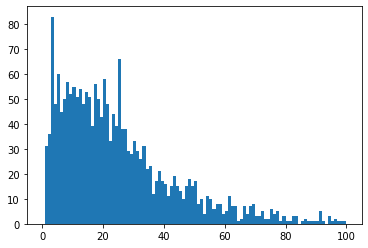

collected 1993 samples
91


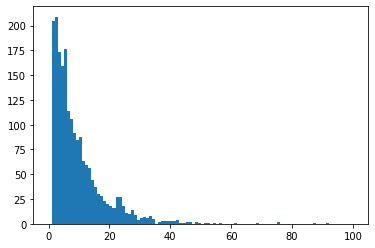

collected 3093 samples
290


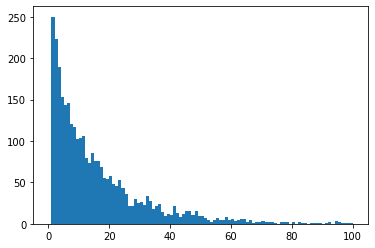

collected 3093 samples
85


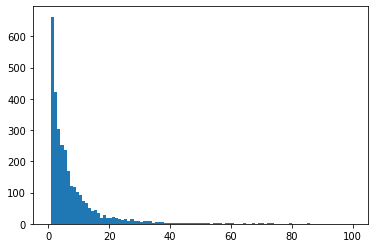

In [7]:
print(f'collected {len(padded_raw_length)} samples')
print(max(padded_raw_length))
plt.figure()
plt.hist(padded_raw_length, np.arange(101))
plt.show()

print(f'collected {len(padded_expert_length)} samples')
print(max(padded_expert_length))
plt.figure()
plt.hist(padded_expert_length, np.arange(101))
plt.show()

print(f'collected {len(bagged_raw_length)} samples')
print(max(bagged_raw_length))
plt.figure()
plt.hist(bagged_raw_length, np.arange(101))
plt.show()

print(f'collected {len(bagged_expert_length)} samples')
print(max(bagged_expert_length))
plt.figure()
plt.hist(bagged_expert_length, np.arange(101))
plt.show()